In [1]:
import sys
print(sys.executable)

C:\Program Files\Python312\python.exe


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
import yfinance as yf


from datetime import date

In [3]:
risk_free = 0.06                             #УКАЖИТЕ ГОДОВОЙ ДОХОД БЕЗРИСКОВЫХ ИНВЕСТИЦИЙ
total_money = 9432            #УКАЖИТЕ НА КАКУЮ СУММУ СОБРАТЬ ПОРТФЕЛЬ

listtick = ['GOOG', 'AMZN', 'AAPL', 'META', 'NVDA', 'MCD', 'TSLA']
#listtick = "aflt.me gazp.me gche.me gltr.me irao.me mgnt.me moex.me mtlr.me 
# mtss.me nkncp.me nvtk.me ozon.me pikk.me poly.me qiwi.me rosn.me rtkm.me 
# sgzh.me sibn.me sngsp.me tatn.me trmk.me vkco.me".upper().split(" ")   #НАПИСАТЬ ТИКЕРЫ ВРУЧНУЮ

k = 200                                          #ИНАЧЕ ВЗЯТЬ k КРУПНЕЙШИХ КОМПАНИЙ NASDAC ИЗ ФАЙЛА
if len(listtick) == 0:
    listtick = pd.read_csv('nasdaq_screener_1684050394168.csv')
    listtick = listtick.sort_values("Market Cap", ascending=False).iloc[:k].Symbol.to_list()

print(listtick)

['GOOG', 'AMZN', 'AAPL', 'META', 'NVDA', 'MCD', 'TSLA']


Скачиваем котировки:

In [4]:
today = str(date.today())
print(today) 

df = yf.download(listtick, start = "2020-01-01", end=today).Close.dropna(axis=1, how='all')
df.tail()

2025-12-30


C:\Users\Admin\AppData\Local\Temp\ipykernel_6084\3026892901.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(listtick, start = "2020-01-01", end=today).Close.dropna(axis=1, how='all')
[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,AMZN,GOOG,MCD,META,NVDA,TSLA
Date,,,,,,,
2025-12-22,270.970001,228.429993,311.329987,316.220001,661.500000,183.690002,488.730011
2025-12-23,272.359985,232.139999,315.679993,310.839996,664.940002,189.210007,485.559998
2025-12-24,273.809998,232.380005,315.670013,313.329987,667.549988,188.610001,485.399994
2025-12-26,273.399994,232.520004,314.959991,310.679993,663.289978,190.529999,475.190002
2025-12-29,273.760010,232.070007,314.390015,308.529999,658.690002,188.220001,459.640015


По приколу выведем котировки 10-ти каких то акций

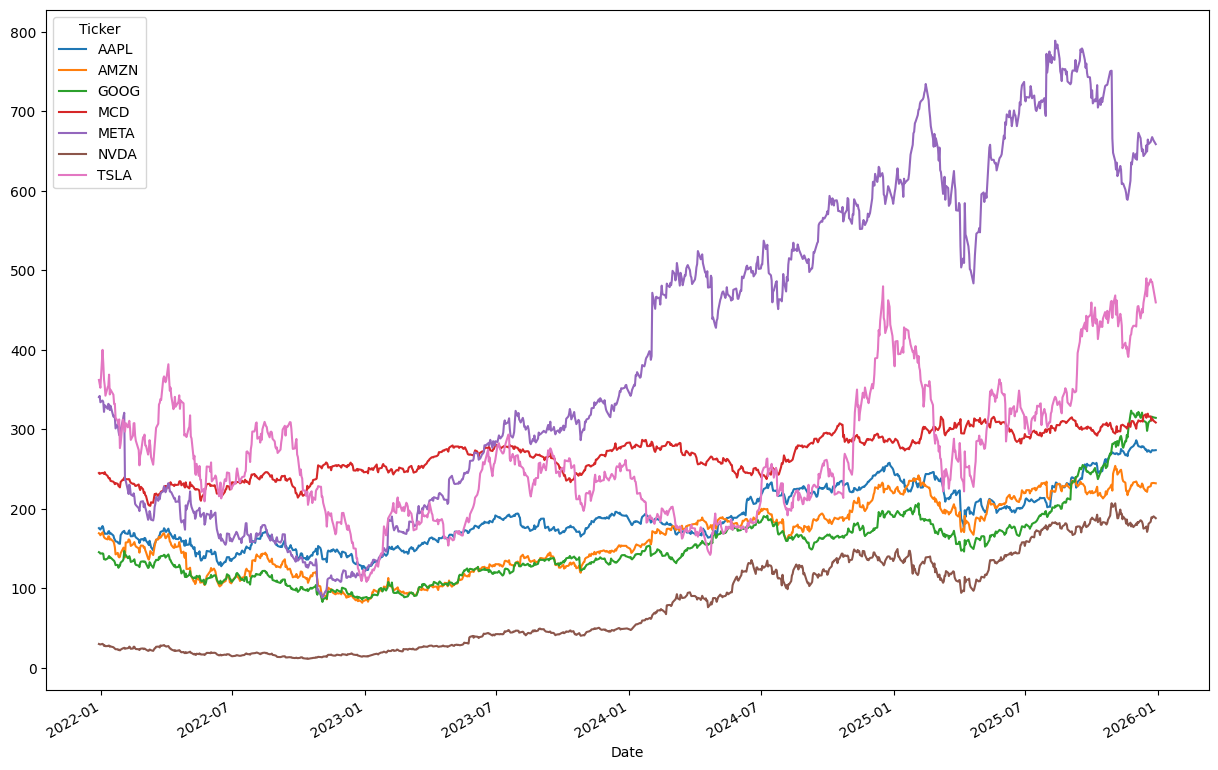

In [5]:
if len(df) >= 10 :
    df.iloc[-1004:, 0:10].plot(figsize=(15,10))
else:
    df.plot(figsize=(15,10))

Теперь сделаем матрицу ковариации наших активов.

<Axes: xlabel='Ticker', ylabel='Ticker'>

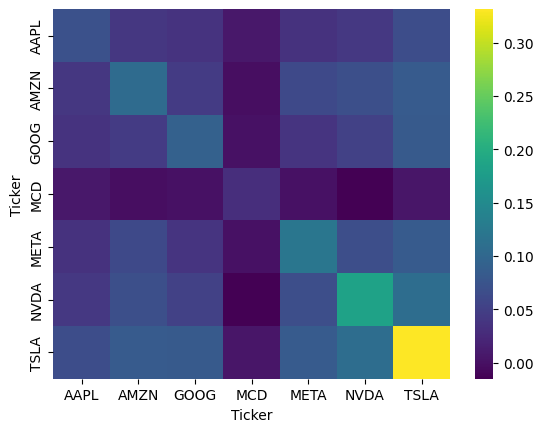

In [6]:
rm = risk_models.risk_matrix(df, method="exp_cov", span=252)
rm = pypfopt.risk_models.fix_nonpositive_semidefinite(rm)

sns.heatmap(rm, cmap='viridis')

Теперь посчитаем оценку для доходностей каждого актива

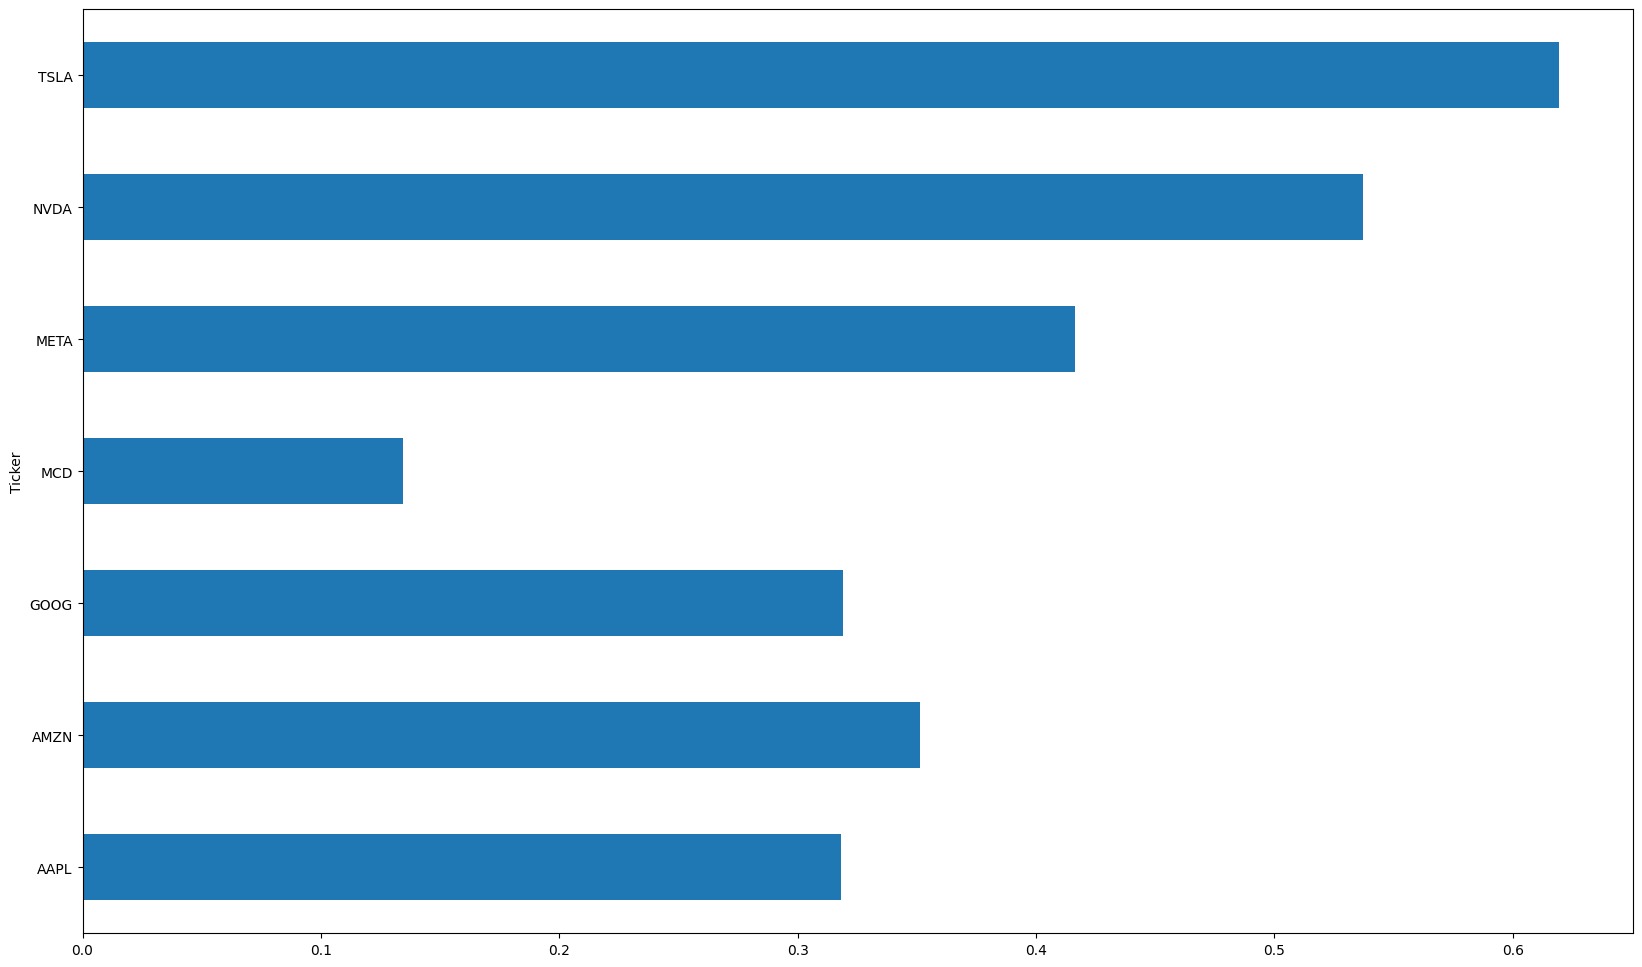

In [7]:
er = expected_returns.return_model(df, method="capm_return")
er.plot.barh(figsize=(20, 12));

Теперь сделаем оптимизацию портфеля

Колличество активов в портфеле:  7
Параметры полученого портфеля: 
Expected annual return: 42.0%
Annual volatility: 26.0%
Sharpe Ratio: 1.38
Полученные веса портфеля: 
NVDA    0.23060
META    0.17414
TSLA    0.16474
AAPL    0.13785
MCD     0.10090
GOOG    0.09982
AMZN    0.09195
dtype: float64

Денежное распределение (USD) при total_money = 9432.0
NVDA    2175.02
META    1642.49
TSLA    1553.83
AAPL    1300.20
MCD      951.69
GOOG     941.50
AMZN     867.27

Проверка: сумма по долларам = 9432.0 из 9432.0


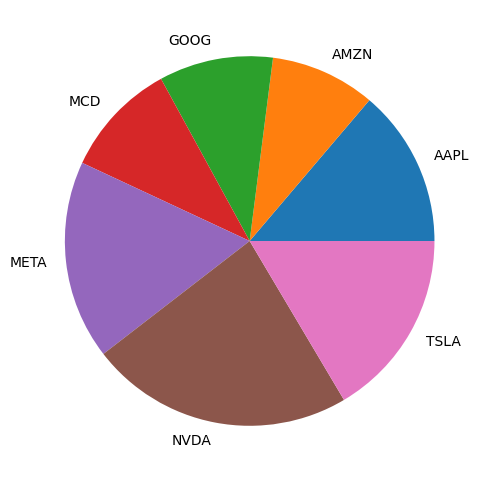

In [11]:
# === оптимизация ===
ef = pypfopt.EfficientFrontier(er, rm)
ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=0.15)  # УВЕЛИЧИТЬ gamma, если хочется больше акций в портфеле

# === ВЫБЕРИТЕ ОДИН РЕЖИМ (раскомментируйте ровно одну строку) ===
# ef.max_sharpe(risk_free_rate=risk_free)                 # максимум Шарпа
# ef.min_volatility()                                    # минимум волатильности
# ef.efficient_risk(target_volatility=0.15)              # таргет-волатильность (пример: 15%)
ef.efficient_return(target_return=0.42)                # таргет-доходность (пример: 20% годовых)
# ef.max_quadratic_utility(risk_aversion=2.0)            # квадратичная полезность (чем больше risk_aversion, тем консервативнее)

print("Колличество активов в портфеле: ", np.count_nonzero(np.array(list(ef.clean_weights().values()))))
print("Параметры полученого портфеля: ")
ef.portfolio_performance(verbose=True, risk_free_rate=risk_free)

print("Полученные веса портфеля: ")
weig = pd.Series(ef.clean_weights())
weig = weig[weig != 0]
print(weig.sort_values(ascending=False))

# === НОВОЕ: денежное распределение по активам (USD) ===
alloc_usd = (weig * float(total_money)).rename("usd")
alloc_usd = alloc_usd.sort_values(ascending=False).round(2)

print("\nДенежное распределение (USD) при total_money =", round(float(total_money), 2))
print(alloc_usd.to_string())

print("\nПроверка: сумма по долларам =", round(alloc_usd.sum(), 2), "из", round(float(total_money), 2))

# ваш пай-чарт (по всем тикерам, включая нулевые веса)
pd.Series(ef.clean_weights(), index = ef.tickers).plot.pie(figsize=(6, 6));


Funds remaining: 63.27
AAPL: allocated 0.141, desired 0.136
AMZN: allocated 0.086, desired 0.073
GOOG: allocated 0.077, desired 0.090
MCD: allocated 0.082, desired 0.096
META: allocated 0.168, desired 0.186
NVDA: allocated 0.265, desired 0.255
TSLA: allocated 0.181, desired 0.164
Allocation has RMSE: 0.013
Дискретный портфель на $7736.73 с остатком денег: $63.27
AAPL     4
AMZN     3
GOOG     2
MCD      2
META     2
NVDA    12
TSLA     3
dtype: int64


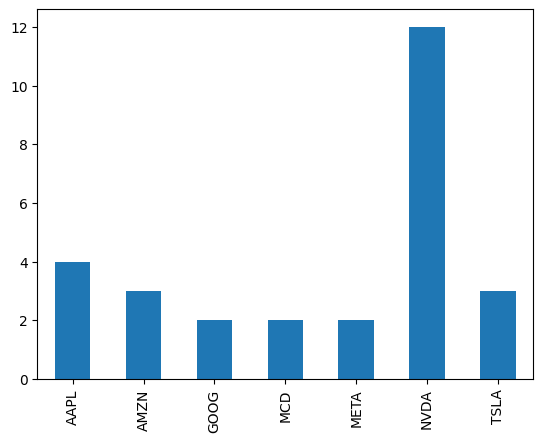

In [10]:
da = pypfopt.DiscreteAllocation(ef.clean_weights(), df.iloc[-1], total_portfolio_value=total_money) #ВЫЧЕСЛИТЬ В ЦЕЛЫХ ЧИСЛАХ
alloc, leftover = da.lp_portfolio(verbose=True)  
print(f"Дискретный портфель на ${(total_money-leftover):.2f} с остатком денег: ${leftover:.2f}")
print(pd.Series(alloc))
pd.Series(alloc).plot.bar();

Далее пример кода показывающий как любой случайный портфель ~~отсасывает~~ проигрывает у портфеля найденного методом оптимизации. Создадим случайные 10000 портфелей и сравним с оптимальным

In [11]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt((w.T * (rm @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.41378814 0.39632917 0.42106978 ... 0.35728896 0.43798069 0.39696347]
Sample portfolio volatilities: 0       0.273710
1       0.273159
2       0.273058
3       0.265889
4       0.236814
          ...   
9995    0.226646
9996    0.286694
9997    0.234795
9998    0.304444
9999    0.280878
Length: 10000, dtype: float64


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


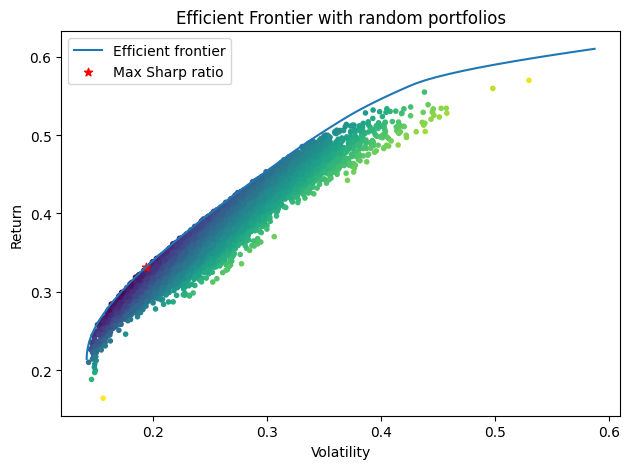

In [12]:
# Plot efficient frontier with Monte Carlo sim
ef = pypfopt.EfficientFrontier(er, rm)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = pypfopt.EfficientFrontier(er, rm)
ef2.max_sharpe(risk_free_rate=risk_free)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", label="Max Sharp ratio", c="red") 
# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

На данном графике по вертикале доходность, а по горизонтали величина отклонения в год. Грубо говоря наше оптимальное решение в год будет приносить 18% $\pm$ 19%  . Любой портфель не находящийся на фронте эффективности хуже.